## Data Downloading and Unzipping

In [2]:
!pip install gdown

In [3]:
!gdown http://drive.google.com/uc?id=1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ
!unzip -q dataset.zip

Downloading...
From (original): http://drive.google.com/uc?id=1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ
From (redirected): https://drive.google.com/uc?id=1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ&confirm=t&uuid=6a6f4e62-2c7d-4dde-b4ba-b2ca4722fdb4
To: /kaggle/working/dataset.zip
100%|██████████████████████████████████████| 1.13G/1.13G [00:11<00:00, 95.2MB/s]


# Import the essential Libraries

In [4]:

import os  # Operating system interaction
import numpy as np  # Numerical computations
from tqdm import tqdm
import matplotlib.pyplot as plt  # Plotting
import torch  # Deep learning framework
import torchvision  # Computer vision utilities
import torch.nn as nn  # Neural network building blocks
import torch.optim as optim  # Optimization algorithms
from torch.autograd import Variable  # Automatic differentiation
from torchvision import datasets, transforms, models  # Pre-trained models
from tqdm.notebook import tqdm  # Progress bars
from sklearn.metrics import roc_auc_score, roc_curve, auc  # ROC curve metrics
from sklearn.preprocessing import label_binarize  # Label binarization

# Set matplotlib backend for inline plotting
%matplotlib inline

# Plotting Images from different classes

Class : no substructure 


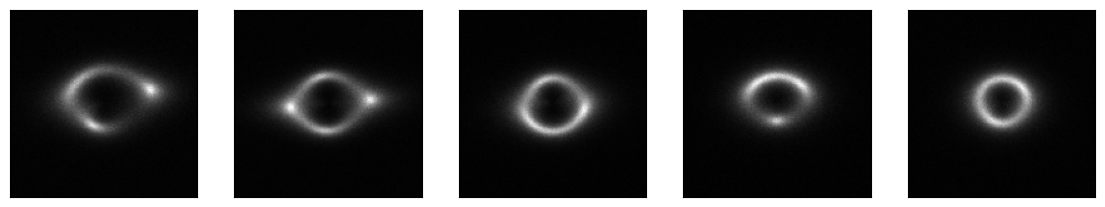

Class : Spherical substructure 


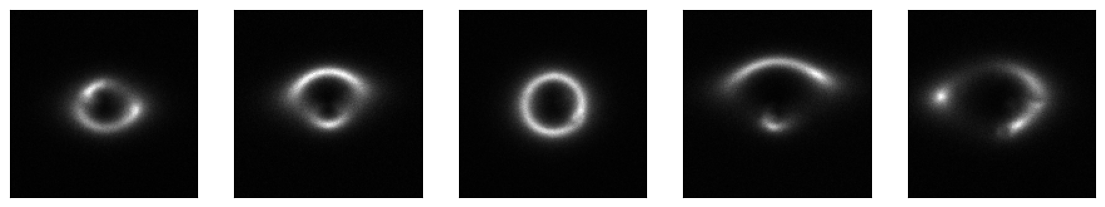

Class : Vortex substructure 


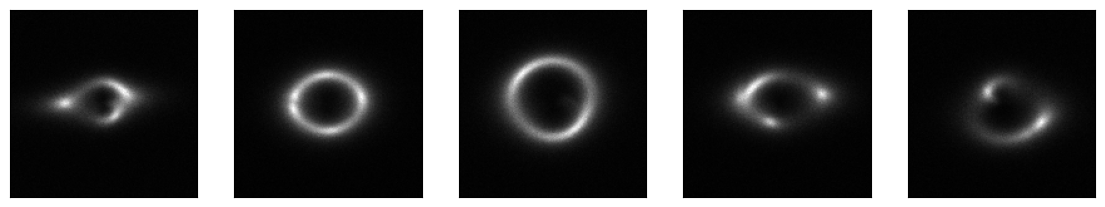

In [5]:
# Defining the input paths for different classes
train_path1 = './dataset/train/no'  # Path for samples with no substructure
train_files1 = [os.path.join(train_path1, f) for f in os.listdir(train_path1) if f.endswith(".npy")]

train_path2 = './dataset/train/sphere'  # Path for samples with spherical substructure
train_files2 = [os.path.join(train_path2, f) for f in os.listdir(train_path2) if f.endswith(".npy")]

train_path3 = './dataset/train/vort'  # Path for samples with vortex substructure
train_files3 = [os.path.join(train_path3, f) for f in os.listdir(train_path3) if f.endswith(".npy")]

# Number of samples to display per class
n = 5

# Plotting the samples with no substructure
print('Class : no substructure ')
plt.rcParams['figure.figsize'] = [14, 14]  # Set the size of the plot
for i, image in enumerate(train_files1[:n], 1):
    ax = plt.subplot(1, n, i)  # Creating subplot
    plt.imshow(np.load(image).reshape(150, 150), cmap='gray')  # Loading and displaying the image
    ax.get_xaxis().set_visible(False)  # Hide x-axis
    ax.get_yaxis().set_visible(False)  # Hide y-axis
plt.show()

# Plotting the samples with spherical substructure
print("Class : Spherical substructure ")
plt.rcParams['figure.figsize'] = [14, 14]
for i, image in enumerate(train_files2[:n], 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(np.load(image).reshape(150, 150), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Plotting the samples with vortex substructure
print("Class : Vortex substructure ")
plt.rcParams['figure.figsize'] = [14, 14]
for i, image in enumerate(train_files3[:n], 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(np.load(image).reshape(150, 150), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Creating Pytorch format Dataset and Dataloder

In [6]:
batch_size = 32  # Batch size for training

def load_img(path):

    tensor = torch.from_numpy(np.load(path))
    tensor = tensor.type('torch.FloatTensor')
    return tensor

def transform_img(img):
      transformer = transforms.Compose([
          transforms.Resize((150, 150)),
          transforms.RandomHorizontalFlip(),
          transforms.RandomVerticalFlip(),
          transforms.RandomRotation(20),
          transforms.Normalize(mean=[0.5], std=[0.5])
      ])
      img = transformer(img)
      return img

# creating training dataset in pytorch format
train_path = "./dataset/train"
train_data = torchvision.datasets.DatasetFolder(root=train_path, loader=load_img,transform= transform_img, extensions="npy")
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# creating validation dataset in pytorch format
val_path = "./dataset/val"
val_data = torchvision.datasets.DatasetFolder(root=val_path, loader=load_img,transform=transform_img, extensions="npy")
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

print("Training Classes: " + str(train_data.class_to_idx))  # Display classes and their indices
print("Validation Classes: " + str(val_data.class_to_idx))

Training Classes: {'no': 0, 'sphere': 1, 'vort': 2}
Validation Classes: {'no': 0, 'sphere': 1, 'vort': 2}


In [7]:

def positionmat(shape):
    midx = midy =  shape/2
    mat = torch.zeros((shape,shape))

    for x in range(shape):
        for y in range(shape):
            dis = ((midx-x)**2 + (midy - y)**2)**0.5
            mat[x][y] = dis
    return mat

# for 150*150 shape image 
mat = positionmat(150)
print(mat)

tensor([[106.0660, 105.3613, 104.6614,  ..., 103.9663, 104.6614, 105.3613],
        [105.3613, 104.6518, 103.9471,  ..., 103.2473, 103.9471, 104.6518],
        [104.6614, 103.9471, 103.2376,  ..., 102.5329, 103.2376, 103.9471],
        ...,
        [103.9663, 103.2473, 102.5329,  ..., 101.8234, 102.5329, 103.2473],
        [104.6614, 103.9471, 103.2376,  ..., 102.5329, 103.2376, 103.9471],
        [105.3613, 104.6518, 103.9471,  ..., 103.2473, 103.9471, 104.6518]])


# EfficientNetB0 Model

In [9]:
class EfficientnetPINN(nn.Module):
    def __init__(self, positionvector=None, batch=32, img_shape=150):
        super(EfficientnetPINN, self).__init__()
        self.positionvector = positionvector
        self.batch = batch
        self.shape = img_shape

        # Encoder  (EfficientNet)
        self.encoder = models.efficientnet_b0(weights=models.efficientnet.EfficientNet_B0_Weights.DEFAULT)
        self.encoder.features[0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.encoder.classifier[1] = nn.Linear(in_features=1280, out_features=img_shape*img_shape, bias=True) # Added a 3 class classifier fully connected layer + 1 Source position predictor

        # Classifier (EfficientNet)
        self.classifier = models.efficientnet_b0(weights=models.efficientnet.EfficientNet_B0_Weights.DEFAULT)
        self.classifier.features[0] = nn.Conv2d(2, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.classifier.classifier[1] = nn.Linear(in_features=1280, out_features=3, bias=True) # Added a 3 class classifier fully connected layer + 1 Source position predictor

    def forward(self, img):
        batch_size = img.shape[0]  # Get batch size dynamically

        lens_img = img  # Store original image
        img = self.encoder(img)  # Pass image through encoder
        img = img.view(batch_size, 1, self.shape, self.shape)  # Reshape output dynamically
        # Ensure positionvector is on the same device as img
        self.positionvector = self.positionvector.to(img.device)
        # Compute deflection
        deflection = (img) * (self.positionvector)

        # Compute source image
        source_img = lens_img - deflection

        # Stack lens and source image into 2-channel input
        twochannel_img = torch.cat((lens_img, source_img), dim=1)  # Shape: (batch_size, 2, img_shape, img_shape)

        # Predict output using classifier
        prediction = self.classifier(twochannel_img)  # Shape: (batch_size, 3)

        return prediction


model = EfficientnetPINN(positionvector = mat)

# Number of trainable Parameters

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of parameters in your CustomDenseNet model
num_params = count_parameters(model)
print(f"Total Trainable Parameters: {num_params}")


Total Trainable Parameters: 36840447


# Connecting Model with GPU

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training the Model

Epoch 1/50
Train Loss: 1.1108, Train Acc: 0.3351
ROC AUC Score: 0.5013


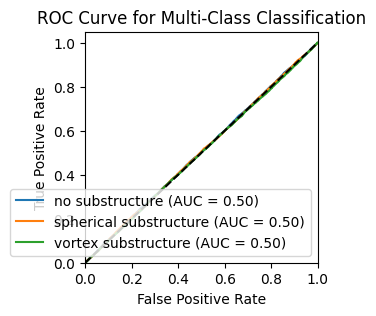

Epoch 2/50
Train Loss: 1.1042, Train Acc: 0.3326
ROC AUC Score: 0.5018


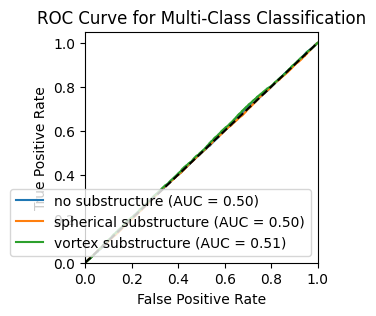

Epoch 3/50
Train Loss: 1.1009, Train Acc: 0.3384
ROC AUC Score: 0.5060


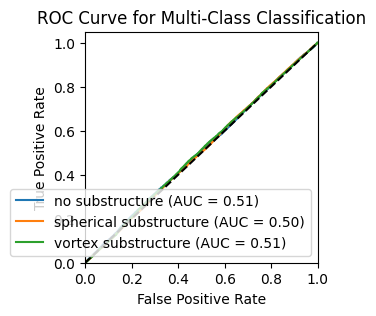

Epoch 4/50
Train Loss: 1.1006, Train Acc: 0.3358
ROC AUC Score: 0.5029


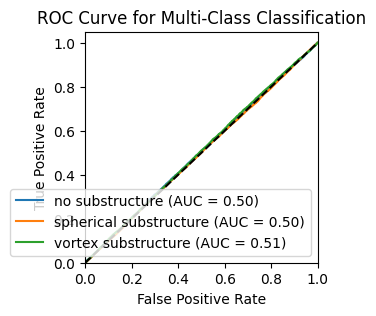

Epoch 5/50
Train Loss: 1.0999, Train Acc: 0.3376
ROC AUC Score: 0.5061


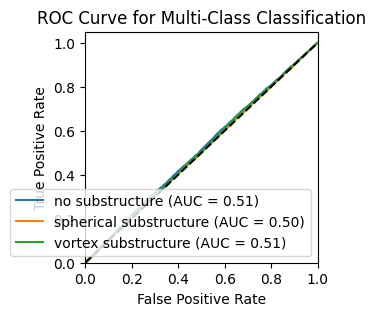

Epoch 6/50
Train Loss: 1.0995, Train Acc: 0.3365
ROC AUC Score: 0.5071


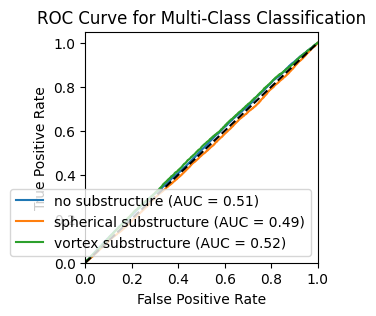

Epoch 7/50
Train Loss: 1.0935, Train Acc: 0.3640
ROC AUC Score: 0.5394


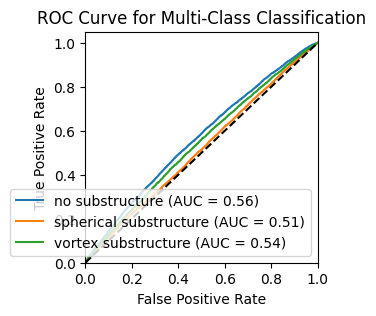

Epoch 8/50
Train Loss: 0.9942, Train Acc: 0.4678
ROC AUC Score: 0.6715


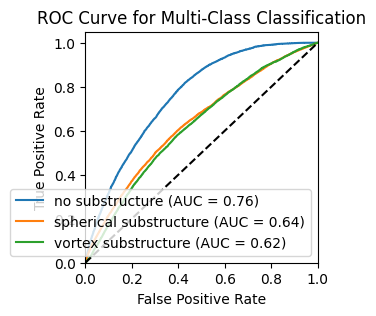

Epoch 9/50
Train Loss: 0.7797, Train Acc: 0.6419
ROC AUC Score: 0.8002


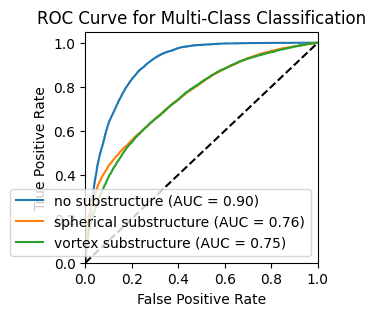

Epoch 10/50
Train Loss: 0.6025, Train Acc: 0.7463
ROC AUC Score: 0.8820


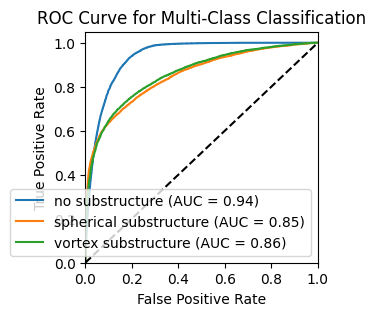

Epoch 11/50
Train Loss: 0.4954, Train Acc: 0.7954
ROC AUC Score: 0.9212


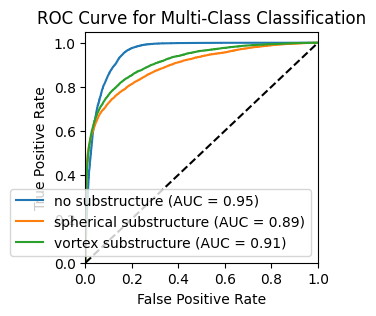

Epoch 12/50
Train Loss: 0.4319, Train Acc: 0.8255
ROC AUC Score: 0.9402


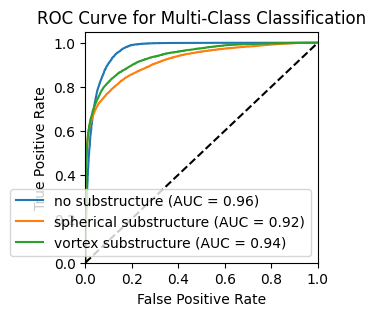

Epoch 13/50
Train Loss: 0.3882, Train Acc: 0.8489
ROC AUC Score: 0.9504


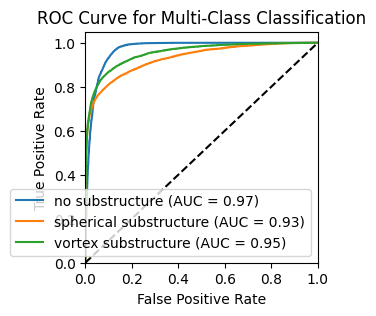

Epoch 14/50
Train Loss: 0.3535, Train Acc: 0.8625
ROC AUC Score: 0.9593


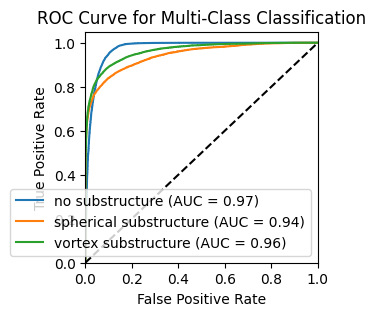

Epoch 15/50
Train Loss: 0.3322, Train Acc: 0.8732
ROC AUC Score: 0.9641


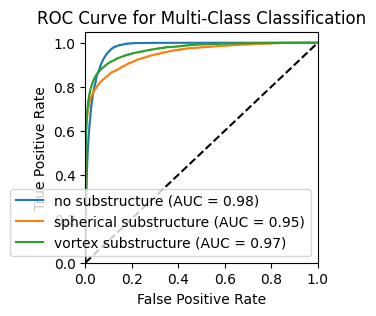

Epoch 16/50
Train Loss: 0.3130, Train Acc: 0.8818
ROC AUC Score: 0.9674


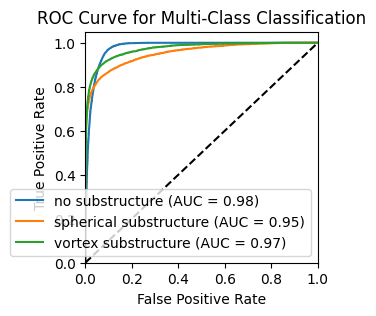

Epoch 17/50
Train Loss: 0.3068, Train Acc: 0.8855
ROC AUC Score: 0.9683


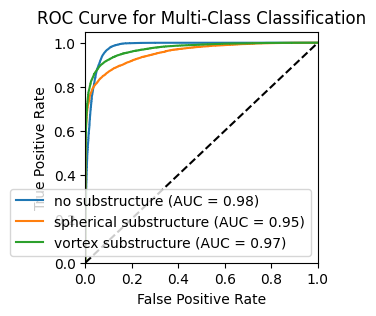

Epoch 18/50
Train Loss: 0.2865, Train Acc: 0.8912
ROC AUC Score: 0.9718


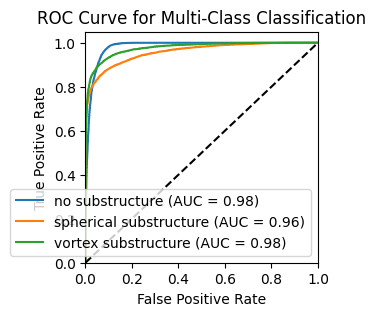

Epoch 19/50
Train Loss: 0.2730, Train Acc: 0.8982
ROC AUC Score: 0.9735


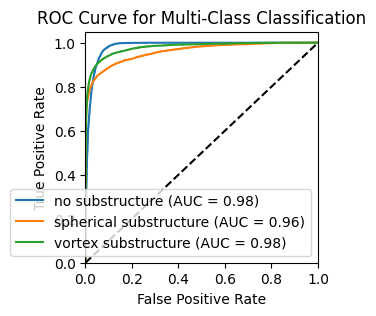

Epoch 20/50
Train Loss: 0.2638, Train Acc: 0.9010
ROC AUC Score: 0.9763


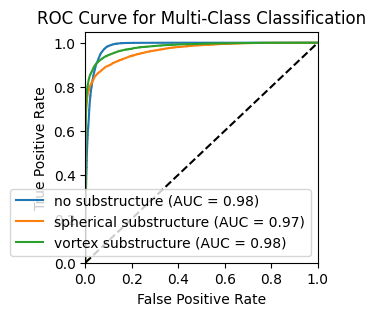

Epoch 21/50
Train Loss: 0.2532, Train Acc: 0.9061
ROC AUC Score: 0.9774


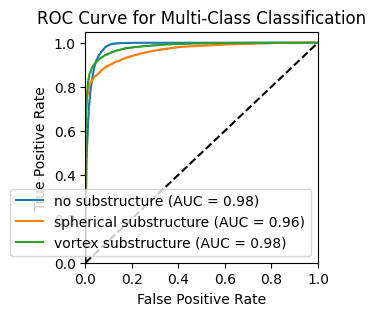

Epoch 22/50
Train Loss: 0.2472, Train Acc: 0.9087
ROC AUC Score: 0.9775


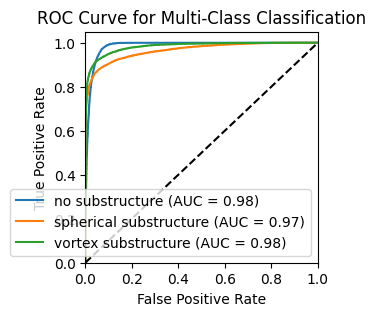

Epoch 23/50
Train Loss: 0.2407, Train Acc: 0.9106
ROC AUC Score: 0.9793


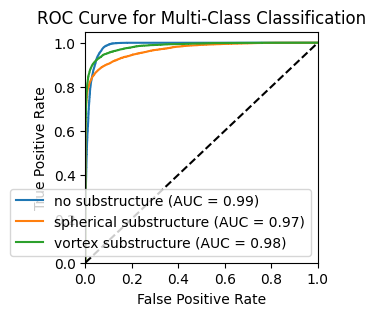

Epoch 24/50
Train Loss: 0.2342, Train Acc: 0.9138
ROC AUC Score: 0.9800


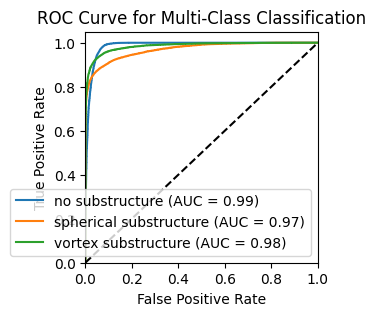

Epoch 25/50
Train Loss: 0.2242, Train Acc: 0.9182
ROC AUC Score: 0.9814


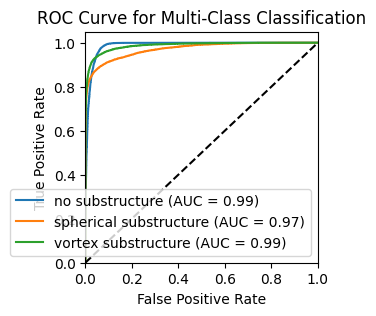

Epoch 26/50
Train Loss: 0.2186, Train Acc: 0.9189
ROC AUC Score: 0.9821


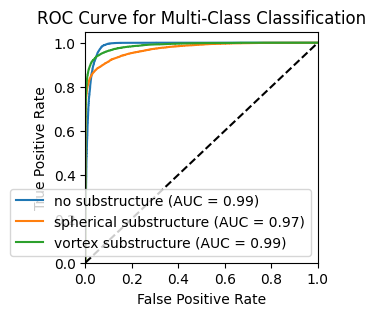

Epoch 27/50
Train Loss: 0.2168, Train Acc: 0.9196
ROC AUC Score: 0.9825


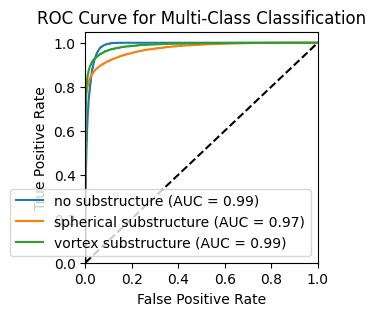

Epoch 28/50
Train Loss: 0.2132, Train Acc: 0.9196
ROC AUC Score: 0.9836


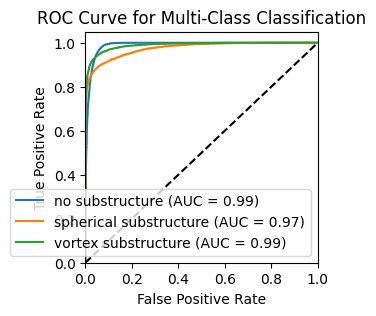

Epoch 29/50
Train Loss: 0.2072, Train Acc: 0.9244
ROC AUC Score: 0.9839


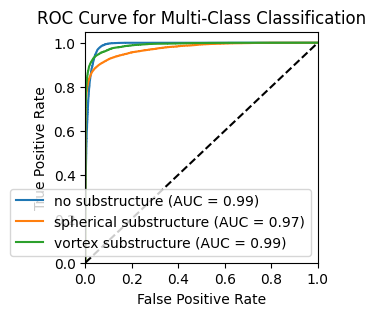

Epoch 30/50
Train Loss: 0.2023, Train Acc: 0.9268
ROC AUC Score: 0.9847


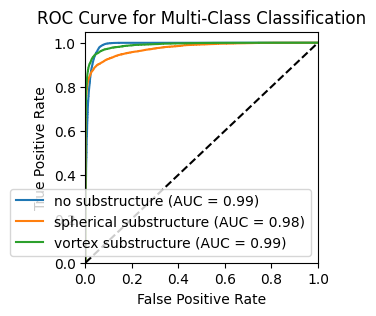

Epoch 31/50
Train Loss: 0.1973, Train Acc: 0.9272
ROC AUC Score: 0.9856


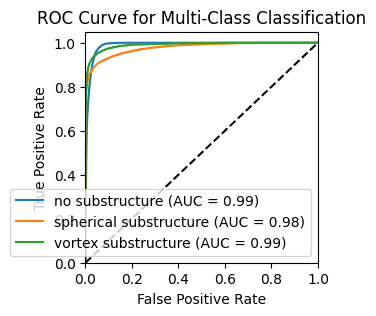

Epoch 32/50
Train Loss: 0.1952, Train Acc: 0.9295
ROC AUC Score: 0.9852


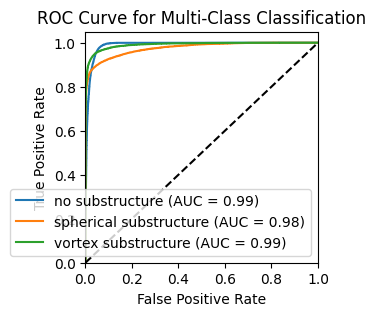

Epoch 33/50
Train Loss: 0.1921, Train Acc: 0.9302
ROC AUC Score: 0.9855


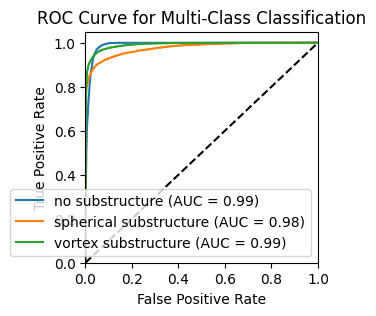

Epoch 34/50
Train Loss: 0.1879, Train Acc: 0.9308
ROC AUC Score: 0.9860


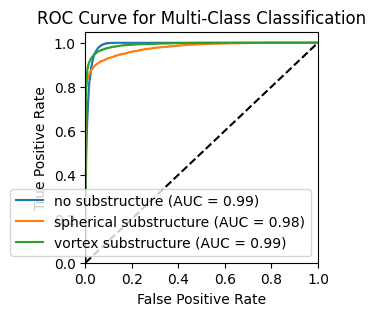

Epoch 35/50
Train Loss: 0.1816, Train Acc: 0.9334
ROC AUC Score: 0.9867


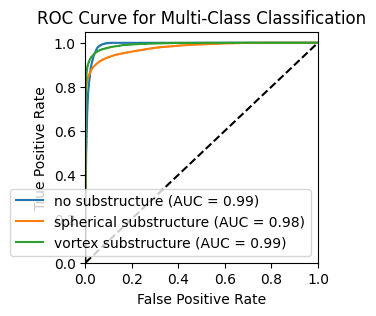

Epoch 36/50
Train Loss: 0.1809, Train Acc: 0.9348
ROC AUC Score: 0.9871


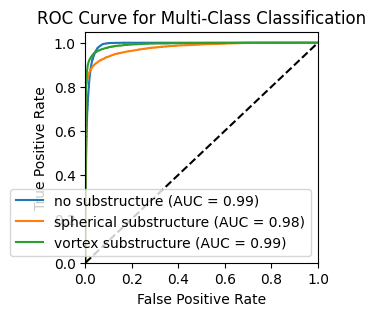

Epoch 37/50
Train Loss: 0.1733, Train Acc: 0.9377
ROC AUC Score: 0.9879


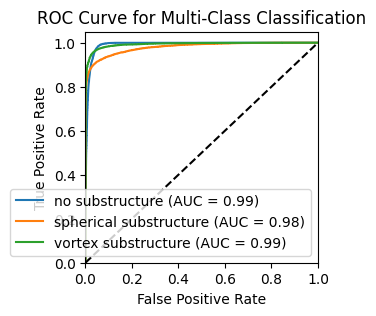

Epoch 38/50
Train Loss: 0.1709, Train Acc: 0.9374
ROC AUC Score: 0.9886


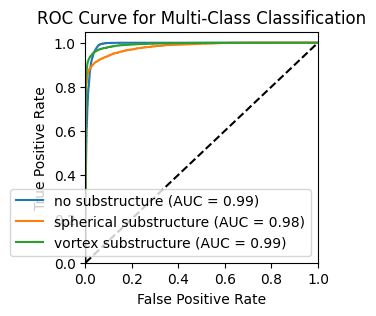

Epoch 39/50
Train Loss: 0.1715, Train Acc: 0.9375
ROC AUC Score: 0.9880


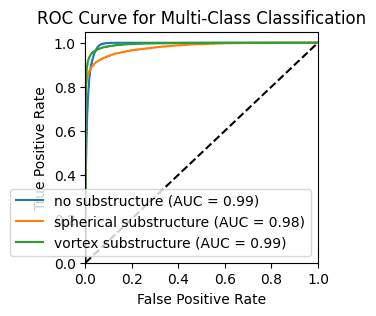

Epoch 40/50
Train Loss: 0.1673, Train Acc: 0.9382
ROC AUC Score: 0.9886


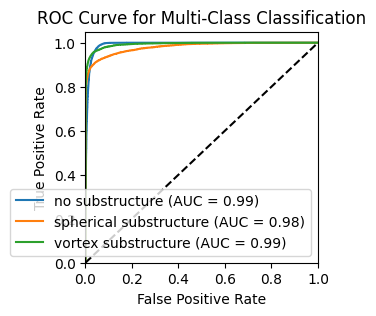

Epoch 41/50
Train Loss: 0.1673, Train Acc: 0.9393
ROC AUC Score: 0.9885


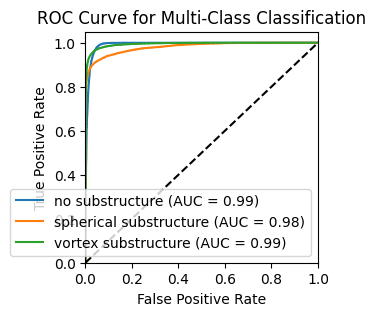

Epoch 42/50
Train Loss: 0.1670, Train Acc: 0.9394
ROC AUC Score: 0.9888


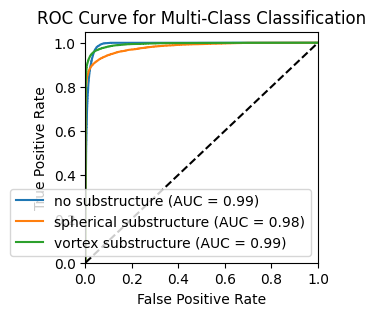

Epoch 43/50
Train Loss: 0.1609, Train Acc: 0.9408
ROC AUC Score: 0.9895


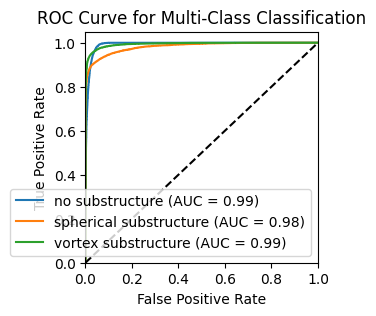

Epoch 44/50
Train Loss: 0.1603, Train Acc: 0.9417
ROC AUC Score: 0.9898


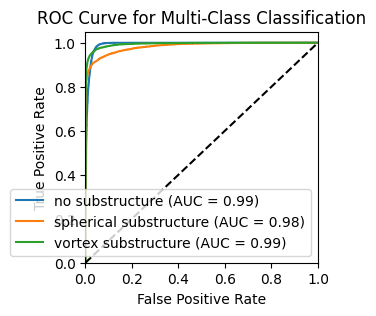

Epoch 45/50
Train Loss: 0.1559, Train Acc: 0.9442
ROC AUC Score: 0.9899


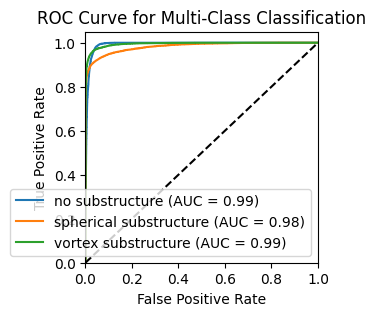

Epoch 46/50
Train Loss: 0.1536, Train Acc: 0.9444
ROC AUC Score: 0.9902


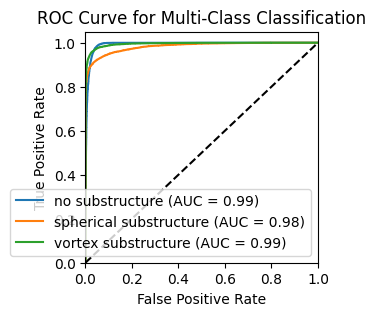

Epoch 47/50
Train Loss: 0.1543, Train Acc: 0.9432
ROC AUC Score: 0.9905


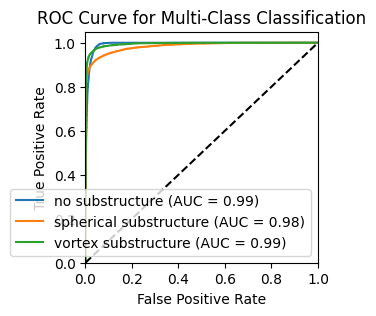

Epoch 48/50
Train Loss: 0.1485, Train Acc: 0.9469
ROC AUC Score: 0.9907


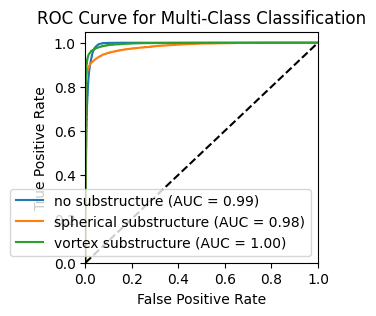

Epoch 49/50
Train Loss: 0.1515, Train Acc: 0.9450
ROC AUC Score: 0.9903


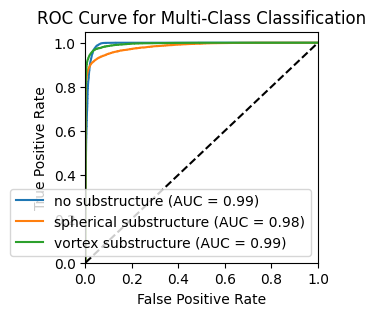

Epoch 50/50
Train Loss: 0.1473, Train Acc: 0.9467
ROC AUC Score: 0.9908


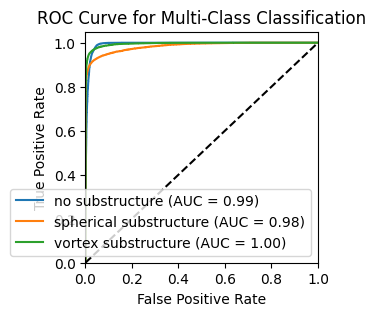

In [12]:

# Training parameters
num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.RAdam(model.parameters(), lr=0.0005)

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    model.train()  # Set model to training mode

    train_loss = 0.0
    correct_predictions = 0
    total_samples = 0  # Keep track of total samples

    y_true = []
    y_scores = []
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        correct_predictions += (preds == labels).sum()
        total_samples += labels.size(0)  # Accumulate total number of samples

        loss = criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        train_loss += loss.item()

        y_true.extend(labels.cpu().numpy())  # Convert labels to NumPy
        y_scores.extend(outputs.detach().cpu().numpy())  # Convert outputs to NumPy

    # Compute average loss and accuracy
    train_loss /= len(train_loader)
    train_acc = correct_predictions / total_samples  # Correct accuracy computation

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # Convert lists to NumPy arrays for ROC-AUC calculation
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # ROC-AUC computation
    n_classes = len(train_data.class_to_idx)  #  len(class_dict) # or len(np.unique(y_true))]
    fpr, tpr, roc_auc = {}, {}, []

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_scores[:, i])
        roc_auc.append(roc_auc_score((y_true == i).astype(int), y_scores[:, i]))

    # Average AUC score
    roc_score = np.mean(roc_auc)
    print(f"ROC AUC Score: {roc_score:.4f}")

    # Plot ROC curve
    plt.figure(figsize=(3,3))
    class_dict = {0: "no substructure", 1: "spherical substructure", 2: "vortex substructure"}

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"{class_dict[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class Classification')
    plt.legend(loc="lower right")
    plt.show()

# Save trained model
torch.save(model.state_dict(), "efficientnet_PINN.pth")


# Evaluating the model on Validation data

Val Loss: 0.1637, Val Acc: 0.9455
ROC AUC Score: 0.9891


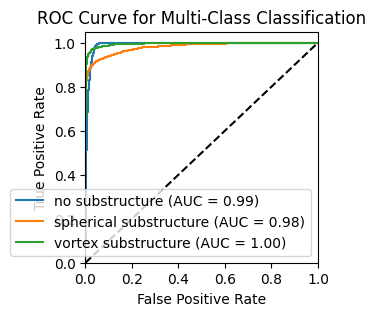

In [13]:
model.eval()  # Set model to evaluation mode

val_loss = 0.0
correct_predictions = 0
total_samples = 0

y_true = []
y_scores = []

with torch.no_grad():  # Disable gradient computation
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

        loss = criterion(outputs, labels)
        val_loss += loss.item() * labels.size(0)  # Accumulate loss

        y_true.extend(labels.cpu().numpy())
        y_scores.extend(outputs.cpu().numpy())

# Compute average loss and accuracy
val_loss /= total_samples
val_acc = correct_predictions / total_samples

print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Convert lists to NumPy arrays for ROC-AUC calculation
y_true = np.array(y_true)
y_scores = np.array(y_scores)

    # ROC-AUC computation
n_classes = len(val_data.class_to_idx)  #  len(class_dict) # or len(np.unique(y_true))]
fpr, tpr, roc_auc = {}, {}, []

for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_scores[:, i])
        roc_auc.append(roc_auc_score((y_true == i).astype(int), y_scores[:, i]))

    # Average AUC score
roc_score = np.mean(roc_auc)
print(f"ROC AUC Score: {roc_score:.4f}")

    # Plot ROC curve
plt.figure(figsize=(3,3))
class_dict = {0: "no substructure", 1: "spherical substructure", 2: "vortex substructure"}

for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"{class_dict[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()